## Лабораторная работа №3 Анализ точности работы алгоритмов дебайеризации

**Цель**

Оценить влияния параметров дебайеризации на точность передачи
изображения с помощью показателей качества изображений и цветового
различия.


In [135]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pandas as pd 

from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from colormath.color_diff import delta_e_cie1976
from colormath.color_conversions import convert_color
from colormath.color_objects import LabColor, sRGBColor

In [107]:
class SuperPixel:
    def __init__(self, image: np.array, name_type: str) -> np.array:
      
         self.result =  self.calc_result(image, name_type)

    def calc_result(self, image: np.array, name_type: str ) -> np.array:
        w, h = image.shape
        result = np.zeros((w // 2, h // 2, 3))
        for y in range(0, h - 2, 2):
            for x in range(0, w - 2, 2):
                vec = image[x:x+2, y:y+2].reshape(-1, 4)[0]

                if name_type == "GRBG":
                    result[x // 2][y // 2] = (vec[1], vec[0] // 2 + vec[3] // 2, vec[2])
                elif name_type == 'GBRG':
                    result[x // 2][y // 2] = (vec[2], vec[0] // 2 + vec[3] // 2, vec[1])
                elif name_type == 'BGGR':
                    result[x // 2][y // 2] = (vec[3], vec[1] // 2 + vec[2] // 2, vec[0])
                elif name_type == 'RGGB':
                    result[x // 2][y // 2] = (vec[0], vec[1] // 2 + vec[2] // 2, vec[3])

        return result.astype(np.uint8)
    

In [108]:
class BilinearInterpolation:
    def __init__(self, image: np.array, name_type: str) -> np.array:
        self.result =  self.calc_result(image, name_type)
    
    def calc_result(self, image: np.array, name_type: str ) -> np.array:
        w, h = image.shape
        result = np.zeros((w - 2, h - 2, 3))
        filters_dict = {
        "GRBG" : [['G', 'R'], ['B', 'G']],
        "GBRG" : [['G', 'B'], ['R', 'G']],
        "BGGR" : [['B', 'G'], ['G', 'R']],
        "RGGB" : [['R', 'G'], ['G', 'B']],
        }
        filt = np.tile(filters_dict[name_type], (w, h))
    
        for y in range(1, h - 1):
            for x in range(1, w - 1):
                roi_img = image[x-1:x+2, y-1:y+2]
                roi_filt = filt[x-1:x+2, y-1:y+2]

                r_mat = np.where(roi_filt != 'R', 0, roi_img)
                r = r_mat.sum() // (roi_filt == 'R').sum()

                g_mat = np.where(roi_filt != 'G', 0, roi_img)
                g = g_mat.sum() // (roi_filt == 'G').sum()

                b_mat = np.where(roi_filt != 'B', 0, roi_img)
                b = b_mat.sum() // (roi_filt == 'B').sum()

                result[x - 1][y - 1] = (r, g, b)
        
        return result.astype(np.uint8)


In [109]:
path_color_cheker = r"E:\GitHub\Mag_2_semester\TechVision\LW_3\images\ColorChecker.png"
path_GRBG = r'E:\GitHub\Mag_2_semester\TechVision\LW_3\images\GRBG.png'

**ColorChecker**

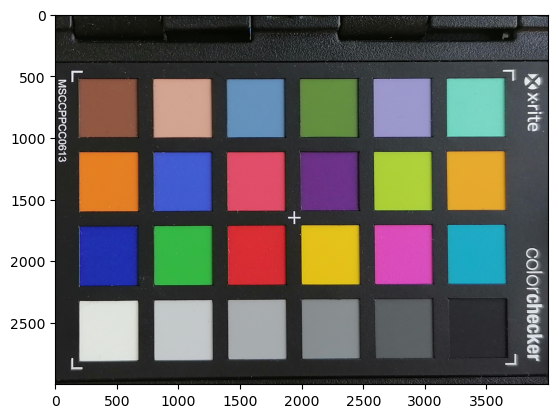

In [110]:
color_cheker_image = cv2.cvtColor(cv2.imread(path_color_cheker), cv2.COLOR_BGR2RGB)
plt.imshow(color_cheker_image)

In [111]:
color_cheker_image.shape

(3000, 4000, 3)

**GRBG**

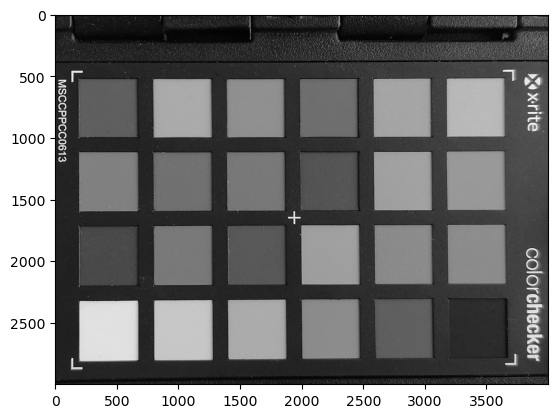

In [112]:
grbg_image = cv2.imread(path_GRBG, cv2.IMREAD_GRAYSCALE)
plt.imshow(grbg_image, cmap='gray')

In [113]:
grbg_image.shape

(3000, 4000)

**SupperPixel**

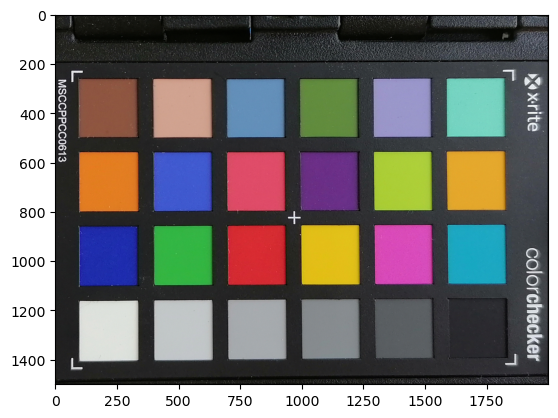

In [114]:
mat_name =  path_GRBG.split("\\")[-1].split('.')[0]
sp_img = SuperPixel(grbg_image, mat_name).result
sp_img = cv2.cvtColor(sp_img, cv2.COLOR_BGR2RGB)
plt.imshow(sp_img)

In [21]:
sp_img.shape

(1500, 2000, 3)

**BilinearInterpolation**

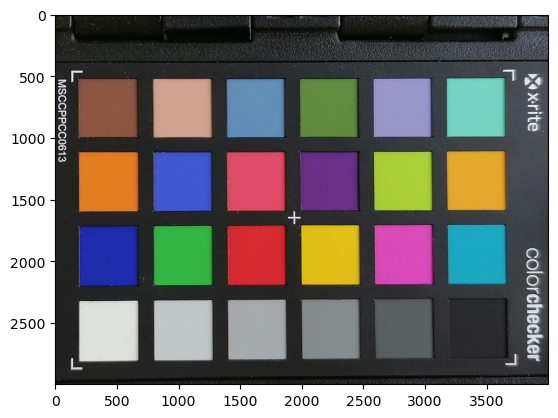

In [23]:
mat_name =  path_GRBG.split("\\")[-1].split('.')[0]
bl_img = BilinearInterpolation(grbg_image, mat_name).result
bl_img = cv2.cvtColor(bl_img, cv2.COLOR_BGR2RGB)
plt.imshow(bl_img)

In [24]:
bl_img.shape

(2998, 3998, 3)

**Увеличение изображений**

In [26]:
h, w, _ = color_cheker_image.shape

sp_img_res = cv2.resize(sp_img, (w,h), cv2.INTER_NEAREST)
bl_img_res = cv2.resize(bl_img, (w,h), cv2.INTER_NEAREST)

In [28]:
print(sp_img_res.shape)
print(bl_img_res.shape)

(3000, 4000, 3)
(3000, 4000, 3)


## Сравнение полученных изображений и ColorChecker

In [38]:
def get_state(im, resize_images):
    MSE_ = ['MSE']
    PSNR_ = ['PSNR']
    SSIM_ = ['SSIM']

    for image in resize_images:
        MSE_.append(round(MSE(im, image), 2))
        PSNR_.append(round(PSNR(im, image,data_range=255), 2))
        SSIM_.append(round(SSIM(im, image, multichannel=True, data_range=255, channel_axis=2),2))
    df = pd.DataFrame(({'func':[], 'sp_img': [], 'bl_img': []}))
    df.loc[ len(df.index )] = MSE_
    df.loc[ len(df.index )] = PSNR_
    df.loc[ len(df.index )] = SSIM_

    return df 

In [39]:
get_state(color_cheker_image, [sp_img_res, bl_img_res])

C:\Users\gongn\AppData\Local\Temp\ipykernel_8512\3223994772.py:9: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM_.append(round(SSIM(im, image, multichannel=True, data_range=255, channel_axis=2),2))


,func,sp_img,bl_img
0,MSE,12.55,28.59
1,PSNR,37.14,33.57
2,SSIM,0.97,0.95


## Усреднение координат RGB

In [104]:
def get_box_images(image):
    boxes = [(1430, 550), (2030, 1150), (230, 1750), (2630, 2350), (3210, 550)]
    w, h = 400, 400
    img = image.copy()
    images = []
    for box in boxes:
        images.append(img[box[1]:box[1] + h, box[0]:box[0] + w])
        # cv2.rectangle(img, box, (box[0] + w, box[1] + h), (255, 0, 0), 3)
        # plt.imshow(img[box[1]:box[1] + h, box[0]:box[0] + w])
        # plt.show()
    return images

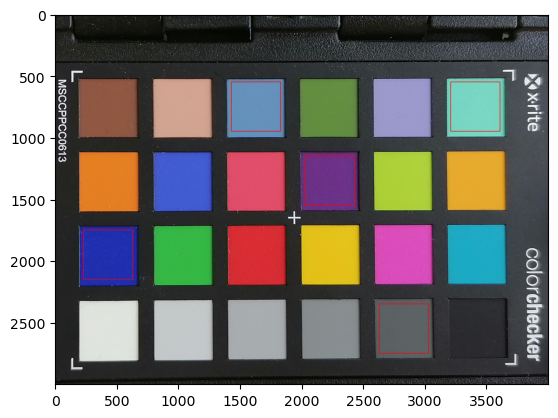

In [81]:
images = get_box_images(color_cheker_image)

In [127]:
def calc_mean(image_box: np.array):
    r = image_box[...,0].mean()
    g = image_box[...,1].mean()
    b = image_box[...,2].mean()
    return [round(r), round(g), round(b)]

In [153]:
def RGB2LAB(rgb_coords):

    rgb = sRGBColor(*[rgb_coords[0]/255, rgb_coords[1]/255, rgb_coords[2]/255])
    color_lab = convert_color(rgb, LabColor)
    
    return  (round(color_lab.lab_l), round(color_lab.lab_a), round(color_lab.lab_b))

In [163]:
def state(im, images):
    images_im = get_box_images(im)
    colors_rgb_im = [calc_mean(image) for image in images_im]
    color_lab_im = [RGB2LAB(rgb) for rgb in colors_rgb_im]

    for image, name in zip(images, ['SuperPixel', 'BilinearInterpolation']):
        image_im = get_box_images(image)
        colors_rgb_image = [calc_mean(image) for image in image_im]   
        color_lab_image = [RGB2LAB(rgb) for rgb in colors_rgb_image]
        df = pd.DataFrame(({'Number':[], 'org_RGB': [], 'org_Lab': [], 'RGB': [],'Lab': [], '∆𝐸76': []}))

        for i in range(5):
            line = [f'{i+1}']
            line.append(colors_rgb_im[i])
            line.append(color_lab_im[i])
            line.append(colors_rgb_image[i])
            line.append(color_lab_image[i])
            line.append(delta_e_cie1976(LabColor(*color_lab_im[i]),LabColor(*color_lab_image[i])))
            df.loc[ len(df.index )] = line
        print(name)
        display(df)
    # SuperPixel
    


In [164]:
pd.options.display.expand_frame_repr = False

In [165]:
state(color_cheker_image, [sp_img_res, bl_img_res])

SuperPixel


,Number,org_RGB,org_Lab,RGB,Lab,∆𝐸76
0,1,"[101, 146, 187]","(59, -4, -26)","[99, 143, 185]","(58, -3, -27)",1.732051
1,2,"[108, 50, 136]","(32, 41, -38)","[106, 47, 134]","(31, 41, -38)",1.000000
2,3,"[32, 47, 175]","(28, 41, -69)","[31, 45, 173]","(27, 42, -69)",1.414214
3,4,"[93, 98, 101]","(41, -1, -2)","[91, 95, 99]","(40, -1, -3)",1.414214
4,5,"[121, 214, 196]","(80, -32, 0)","[119, 212, 194]","(79, -32, 0)",1.000000


BilinearInterpolation


,Number,org_RGB,org_Lab,RGB,Lab,∆𝐸76
0,1,"[101, 146, 187]","(59, -4, -26)","[99, 143, 185]","(58, -3, -27)",1.732051
1,2,"[108, 50, 136]","(32, 41, -38)","[106, 48, 134]","(32, 41, -38)",0.000000
2,3,"[32, 47, 175]","(28, 41, -69)","[30, 45, 173]","(27, 42, -69)",1.414214
3,4,"[93, 98, 101]","(41, -1, -2)","[91, 95, 99]","(40, -1, -3)",1.414214
4,5,"[121, 214, 196]","(80, -32, 0)","[119, 212, 194]","(79, -32, 0)",1.000000


## Вывод
В результате выполнения лабораторной работы была произведена оценка влияния параметров дебайеризации на точность передачи изображения с помощью метрик качества изображений и цветового различия.

По полученным таблицам можно сделать вывод, что реализованные алгоритмы дебайеризации, SuperPixel и Билинейная интерполяция, имеют практически одинаковые координаты цветов RGB, Lab и ∆𝐸76, оба метода показывают хороший результат.